## ARIMA model Exponantioal 4

삼성 주가 예측 하기 


<br>
</br>

칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume  

날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.  


종가 : (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)



In [103]:
!pip install pandas_datareader

In [104]:
!pip install pmdarima

In [105]:
import os 
import pandas as pd 
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import ndiffs
from pmdarima.arima import auto_arima

import numpy as np
import seaborn as sns

In [106]:
%matplotlib inline
import itertools

In [107]:
data = pd.read_csv("./ARIMA_data/005930.KS.csv")
data = data["Close"]  # close 데이터만 다루겠다 


In [108]:
data = np.log(data) # 분산 안정화 시킨다 

In [109]:
 #80퍼로 train size 나누겠다 
    

y_train = data[:int(len(data)*0.8)]
y_test = data[int(len(data)*0.8):]



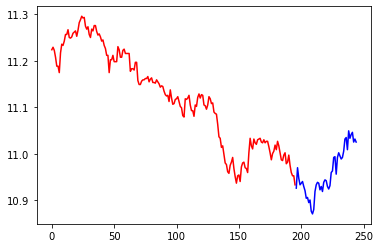

In [110]:
# 시각화 하기 
y_train.plot(c="r")
y_test.plot(c="b")
plt.show()

non stationary인것을 알수있다  
하향 하는 trend 있지만 최근에는 늘어났다 계절성이나 주기는 확인 되지 않는다 

In [111]:
# 몇 차분이 필요한지 알아보기 

kpass_diff = ndiffs(y_train,alpha=0.05,test="kpss",max_d=6)

adf_diffs = ndiffs(y_train,alpha=0.05,test="adf",max_d=6)
n_diffs = max(adf_diffs,kpass_diff)

print("추정된 차수 d {} ".format(n_diffs)) # 1로 차분 하자 


추정된 차수 d 1 


###  ARIMA 모델 분석 하기 

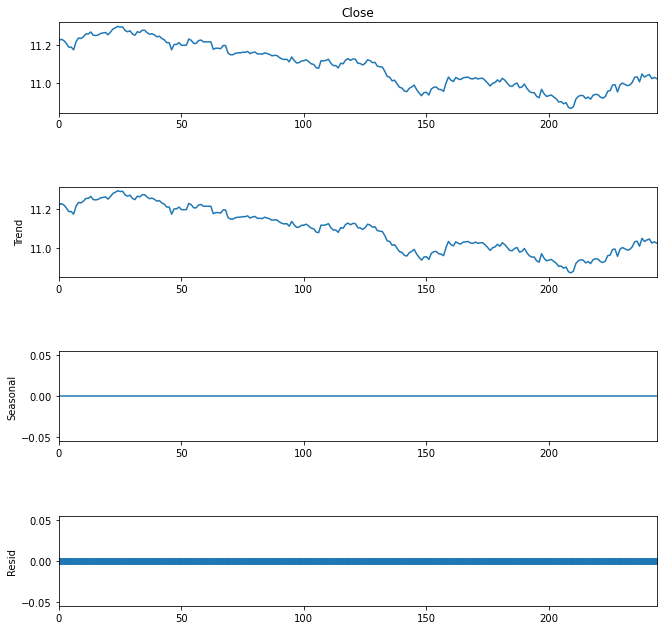

In [112]:
decomposition = sm.tsa.seasonal_decompose(data,model ="additive",period=1)

fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()


C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



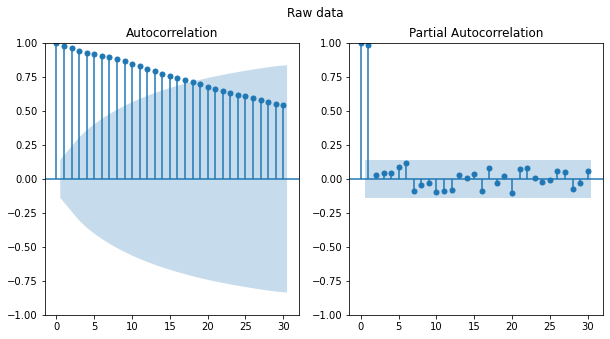

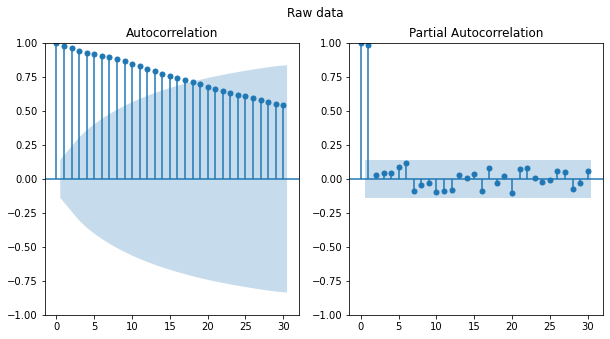

In [113]:
# ACF , PACF 그리기 
fig,ax = plt.subplots(1,2,figsize=(10,5))

fig.suptitle("Raw data")
plot_acf(y_train.values.squeeze(),lags=30,ax=ax[0])
plot_pacf(y_train.values.squeeze(),lags=30,ax=ax[1])

ACF가 천천히 줄어드는 것을 확인할수있듯이 non stationary하다 추정한 차분 계수 1로 차분 진행하고 결과 비교를 해본다 


In [114]:
differencing_data = y_train.copy()
differencing_data = differencing_data.diff()

# 결측치 제거 
differencing_data = differencing_data.dropna()

print("######## TRAIN DATA ##################")
print(y_train)

print("############### 1 DIFFERENCING #########################")
print(differencing_data)

######## TRAIN DATA ##################
0      11.223909
1      11.229235
2      11.222573
3      11.207758
4      11.188579
         ...    
191    10.975071
192    10.959540
193    10.952559
194    10.952559
195    10.933107
Name: Close, Length: 196, dtype: float64
############### 1 DIFFERENCING #########################
1      0.005326
2     -0.006662
3     -0.014815
4     -0.019179
5      0.000000
         ...   
191   -0.022016
192   -0.015531
193   -0.006981
194    0.000000
195   -0.019452
Name: Close, Length: 195, dtype: float64


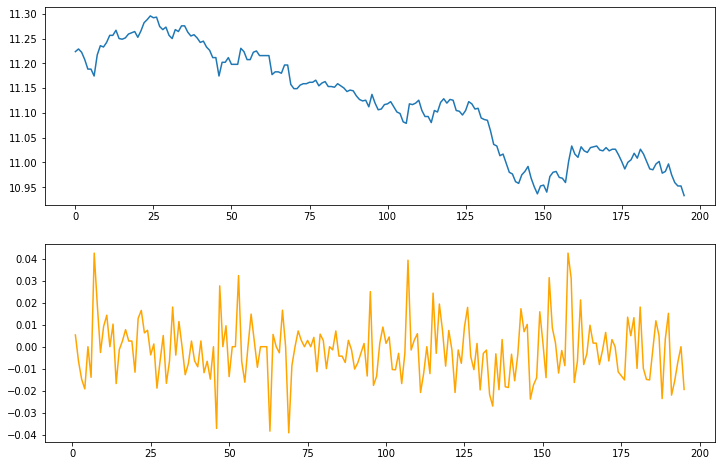

In [115]:
# differencing plot 
plt.figure(figsize=(12,8))
plt.subplot(211)
y_train.plot()


plt.subplot(212)
differencing_data.plot(color="orange")
plt.show()

C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



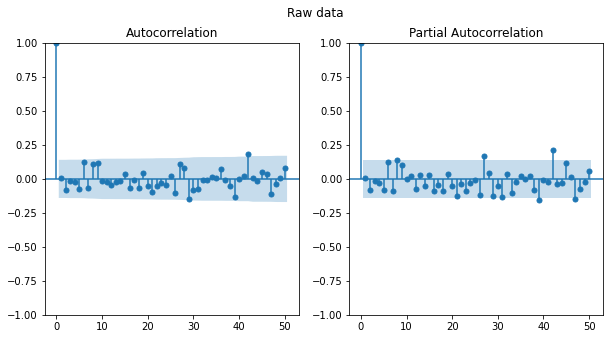

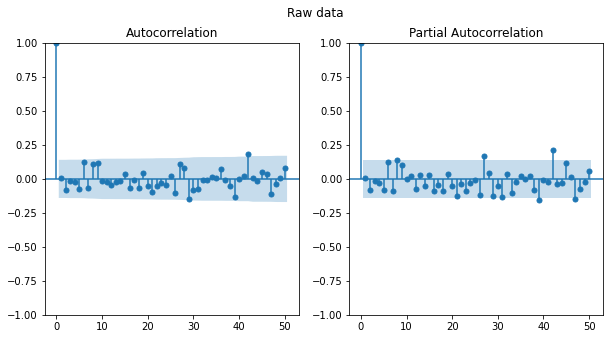

In [116]:
# 차분한 결과 acf pacf 보기 
fig,ax = plt.subplots(1,2,figsize=(10,5))

fig.suptitle("Raw data")
# acf, pacf plt 그리기 

plot_acf(differencing_data.values.squeeze(),lags=50,ax=ax[0])
plot_pacf(differencing_data.values.squeeze(),lags=50,ax=ax[1])

## ARIMA 파라미터 정해보기 


In [117]:
# p = range(5,28)
# d=range(1,2)
# q = range(5,28)

# pdq = list(itertools.product(p,d,q))

# aic=[]

# for i in pdq:
#     model = sm.tsa.arima.ARIMA(y_train.values,order=(i))
#     model_fit = model.fit()
#     print("ARIMA {} >> AIC {}".format(i,round(model_fit.aic,2)))
#     aic.append(round(model_fit.aic,2))
    
print("""
    시간 너무 오래 걸리는데 
    
    [((5, 1, 6), -1116.01)] 찾은 결과가 이러 하니까 auto arima로 이 주변을 다시 찾아 보겠다
    다시 찾은 결과 0 1 0 배열이 더 좋은 aic 결과값이 나왔다 
""")


    시간 너무 오래 걸리는데 
    
    [((5, 1, 6), -1116.01)] 찾은 결과가 이러 하니까 auto arima로 이 주변을 다시 찾아 보겠다
    다시 찾은 결과 0 1 0 배열이 더 좋은 aic 결과값이 나왔다 



In [118]:
# auto arima 적용 하기 
model_arima= auto_arima(y_train,trace=True,d=1,error_action='ignore', start_p=0,start_q=0,max_p=5,max_q=5,
                        suppress_warnings=True,
                        stepwise=False,seasonal=False)

model_arima.fit(y_train)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1126.266, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1124.273, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1123.632, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1121.792, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-1119.794, Time=0.20 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-1119.572, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1124.272, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1122.300, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1121.534, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1122.148, Time=0.31 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-1117.909, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1123.603, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1121.717, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1119.655, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1117.743, Time=0.24

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [119]:
 #자동으로 맞춰저있다 
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  196
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 565.133
Date:                Tue, 22 Nov 2022   AIC                          -1126.266
Time:                        01:20:12   BIC                          -1119.720
Sample:                             0   HQIC                         -1123.615
                                - 196                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0015      0.001     -1.516      0.129      -0.003       0.000
sigma2         0.0002   1.45e-05     12.252      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

AIC 점수는 -1126.266   
Prob(Q)는 0.93이므로 귀무가설을 기각 하지 못하므로 residual은 백색소음 시계열을 따른다 
Prob(JB): 0.00이니까 귀무가설을 기각 할수있다 잔차가 정규성을 만족한다는 귀무가설이 기각 되었으므로 잔차가 정규성을 따르지 않다라고 결론을 낼수있다 


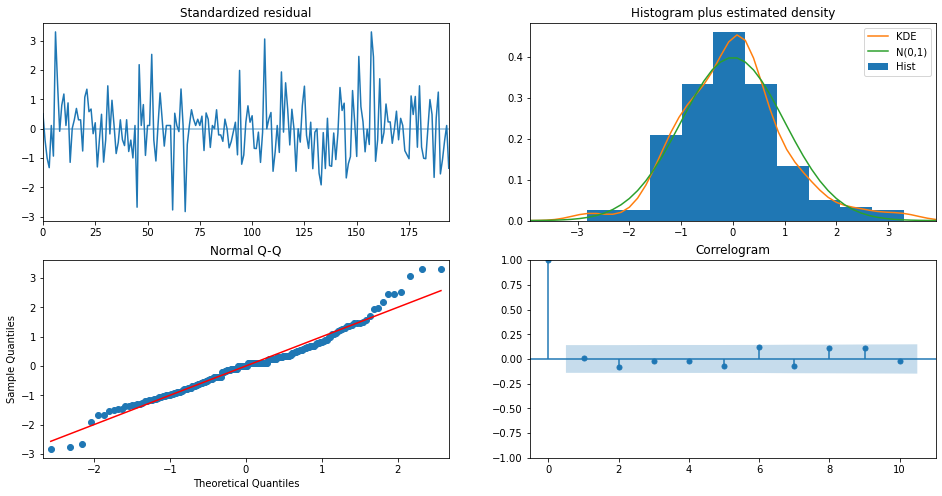

In [120]:
model_arima.plot_diagnostics(figsize=(16,8))
plt.show()

Correlgram을 보면 잔차에 대한 ACF가 범위내에 있음을 확인할수있다 


In [121]:
prediction = model_arima.predict(n_periods=len(y_test))


prediction = pd.DataFrame(prediction,index=y_test.index,columns=["Prediction"])



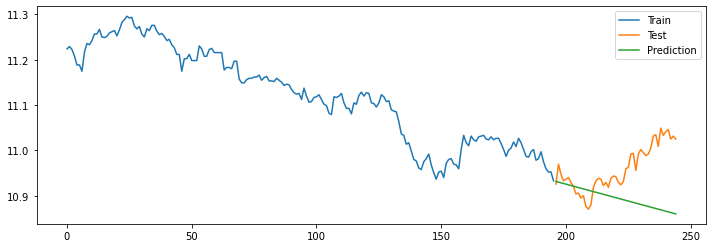

In [122]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
plt.plot(y_train,label="Train")
plt.plot(y_test,label="Test")
plt.plot(prediction,label="Prediction")
plt.legend()
plt.show()

In [123]:
def forecast_one_step():
    fc,conf_int = model_arima.predict(n_periods=1,return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )


한스텝식 예측하고 테스트 데이터를 관측할때마다 모형을 업데이트 해주는 refresh전략 
위에 n_period=1들어간 이유가 위와 같다 

-> 예측치들은 결국 가장 마지막 관측치가 되기 때문이다 
결과적으로 데이터에서 어떠한 구조를 보기 어렵기 때문에 가장 마지막 관측치가 가장 좋은 예측치다라고 말하는거이다 



In [124]:
forecasts=[]
y_pred=[]
pred_upper=[]
pred_lower=[]

for new_ob in y_test:
    fc,conf =forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[0])
    pred_lower.append(conf[1])
    
    model_arima.update(new_ob)
    
    

In [125]:
pd.DataFrame({"test":y_test,"pred":y_pred})

,test,pred
196,10.925938,10.931616
197,10.969921,10.924413
198,10.947292,10.968627
199,10.933107,10.945895
200,10.936672,10.931639
201,10.940224,10.935231
202,10.929529,10.938808
203,10.920528,10.928067
204,10.904119,10.919029
205,10.905956,10.902548


In [126]:
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  245
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 688.831
Date:                Tue, 22 Nov 2022   AIC                          -1373.662
Time:                        01:20:15   BIC                          -1366.668
Sample:                             0   HQIC                         -1370.845
                                - 245                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0008      0.001     -0.849      0.396      -0.003       0.001
sigma2         0.0002   1.57e-05     13.132      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.37   Jarque-

In [127]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


fig = go.Figure([
    go.Scatter(x=y_train.index,y=y_train,name="Train",mode="lines",line= dict(color="royalblue"))
    ,go.Scatter(x=y_test.index,y=y_test,name="Test",mode="lines",line= dict(color="rgba(0,0,30,0.5)"))
    ,go.Scatter(x=y_test.index,y=y_pred,name="Prediction",mode="lines",line= dict(color="red",dash="dot"))
    ,go.Scatter(x=y_test.index.tolist()+y_test.index[::-1].tolist(),y=pred_upper+pred_lower[::-1],fill="toself",
               fillcolor="rgba(0,0,30,0.1)",line=dict(color="rgba(0,0,0,0)"),
               hoverinfo="skip",
               showlegend=False)
])

fig.update_layout(height=400,width=1000)
fig.show()

In [128]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [129]:

mse = mean_squared_error(np.exp(y_test), np.exp(prediction))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(y_test), np.exp(prediction))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(y_test), np.exp(prediction)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(y_pred) - np.exp(y_test))/np.abs(np.exp(y_test)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  27537497.70750214
MAE:  3996.765659258152
RMSE:  5247.618289043339
MAPE: 1.37%


In [130]:
data = pd.read_csv("./ARIMA_data/000660.KS.csv")
data = data["Close"]  # close 데이터만 다루겠다 


In [131]:
data = np.log(data) # 분산 안정화 시킨다 

In [132]:
 #80퍼로 train size 나누겠다 
    

y_train = data[:int(len(data)*0.8)]
y_test = data[int(len(data)*0.8):]



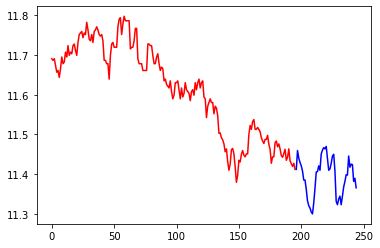

In [133]:
# 시각화 하기 
y_train.plot(c="r")
y_test.plot(c="b")
plt.show()

non stationary인것을 알수있다  
하향 하는 trend 있지만 최근에는 늘어났다 계절성이나 주기는 확인 되지 않는다 

In [134]:
# 몇 차분이 필요한지 알아보기 

kpass_diff = ndiffs(y_train,alpha=0.05,test="kpss",max_d=6)

adf_diffs = ndiffs(y_train,alpha=0.05,test="adf",max_d=6)
n_diffs = max(adf_diffs,kpass_diff)

print("추정된 차수 d {} ".format(n_diffs)) # 1로 차분 하자 


추정된 차수 d 1 


###  ARIMA 모델 분석 하기 

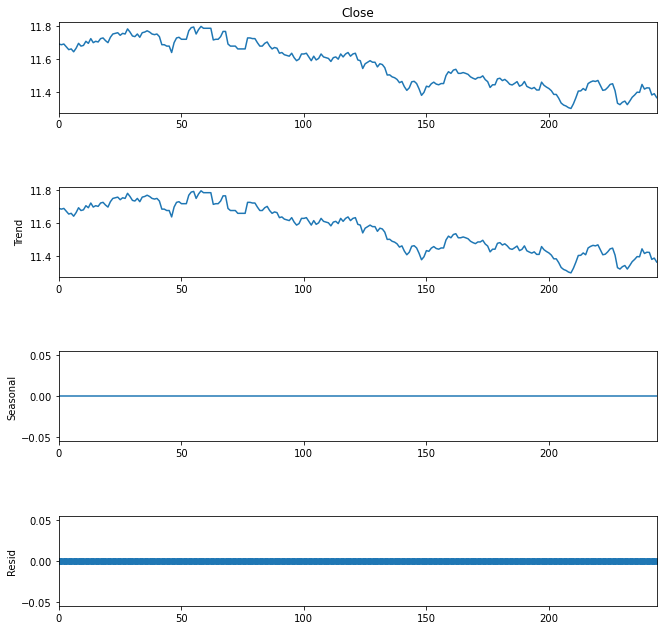

In [135]:
decomposition = sm.tsa.seasonal_decompose(data,model ="additive",period=1)

fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()


C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



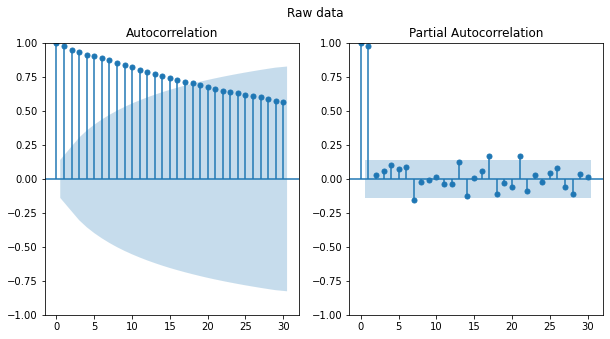

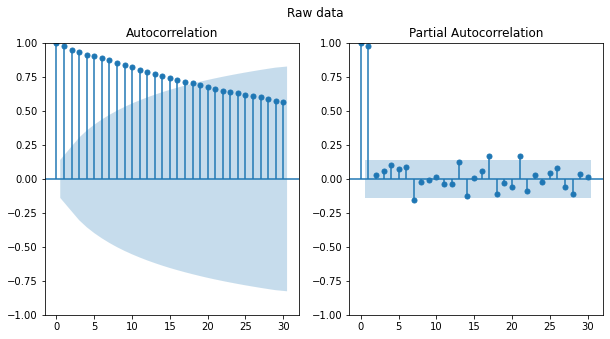

In [136]:
# ACF , PACF 그리기 
fig,ax = plt.subplots(1,2,figsize=(10,5))

fig.suptitle("Raw data")
plot_acf(y_train.values.squeeze(),lags=30,ax=ax[0])
plot_pacf(y_train.values.squeeze(),lags=30,ax=ax[1])

ACF가 천천히 줄어드는 것을 확인할수있듯이 non stationary하다 추정한 차분 계수 1로 차분 진행하고 결과 비교를 해본다 


In [137]:
differencing_data = y_train.copy()
differencing_data = differencing_data.diff()

# 결측치 제거 
differencing_data = differencing_data.dropna()

print("######## TRAIN DATA ##################")
print(y_train)

print("############### 1 DIFFERENCING #########################")
print(differencing_data)

######## TRAIN DATA ##################
0      11.691072
1      11.686879
2      11.691072
3      11.674194
4      11.657026
         ...    
191    11.433882
192    11.426278
193    11.419713
194    11.427368
195    11.412000
Name: Close, Length: 196, dtype: float64
############### 1 DIFFERENCING #########################
1     -0.004193
2      0.004193
3     -0.016878
4     -0.017168
5      0.004320
         ...   
191   -0.029853
192   -0.007605
193   -0.006565
194    0.007654
195   -0.015368
Name: Close, Length: 195, dtype: float64


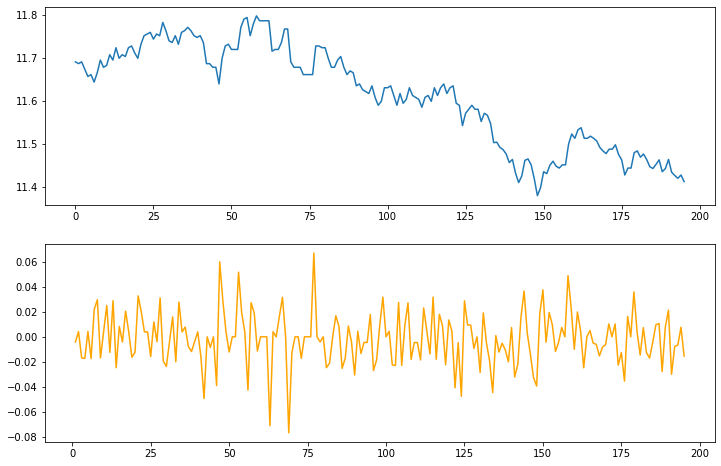

In [138]:
# differencing plot 
plt.figure(figsize=(12,8))
plt.subplot(211)
y_train.plot()


plt.subplot(212)
differencing_data.plot(color="orange")
plt.show()

C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



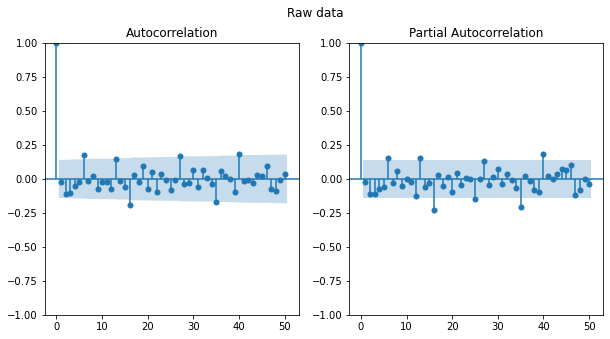

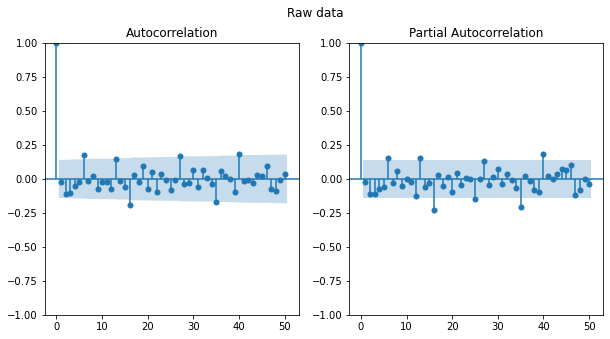

In [139]:
# 차분한 결과 acf pacf 보기 
fig,ax = plt.subplots(1,2,figsize=(10,5))

fig.suptitle("Raw data")
# acf, pacf plt 그리기 

plot_acf(differencing_data.values.squeeze(),lags=50,ax=ax[0])
plot_pacf(differencing_data.values.squeeze(),lags=50,ax=ax[1])

## ARIMA 파라미터 정해보기 


In [140]:
# p = range(5,28)
# d=range(1,2)
# q = range(5,28)

# pdq = list(itertools.product(p,d,q))

# aic=[]

# for i in pdq:
#     model = sm.tsa.arima.ARIMA(y_train.values,order=(i))
#     model_fit = model.fit()
#     print("ARIMA {} >> AIC {}".format(i,round(model_fit.aic,2)))
#     aic.append(round(model_fit.aic,2))
    
print("""
    시간 너무 오래 걸리는데 
    
    [((5, 1, 6), -1116.01)] 찾은 결과가 이러 하니까 auto arima로 이 주변을 다시 찾아 보겠다
    다시 찾은 결과 0 1 0 배열이 더 좋은 aic 결과값이 나왔다 
""")


    시간 너무 오래 걸리는데 
    
    [((5, 1, 6), -1116.01)] 찾은 결과가 이러 하니까 auto arima로 이 주변을 다시 찾아 보겠다
    다시 찾은 결과 0 1 0 배열이 더 좋은 aic 결과값이 나왔다 



In [141]:

# p = range(15,21)
# d=range(1,2)
# q = range(15,21)

# pdq = list(itertools.product(p,d,q))

# aic=[]

# for i in pdq:
#     model = sm.tsa.arima.ARIMA(y_train.values,order=(i))
#     model_fit = model.fit()
#     print("ARIMA {} >> AIC {}".format(i,round(model_fit.aic,2)))
#     aic.append(round(model_fit.aic,2))
    

In [142]:
# auto arima 적용 하기 
model_arima= auto_arima(y_train,trace=True,d=1,error_action='ignore', start_p=0,start_q=0,max_p=3,max_q=3,
                        suppress_warnings=True,
                        stepwise=False,seasonal=False)

model_arima.fit(y_train)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-951.505, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-949.605, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-950.674, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-950.391, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-949.586, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-947.597, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-947.202, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-948.462, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-950.029, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-947.584, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-946.484, Time=0.29 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-950.218, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-949.043, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-946.884, Time=0.33 sec

Best model:  A

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [143]:
 #자동으로 맞춰저있다 
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  196
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 477.753
Date:                Tue, 22 Nov 2022   AIC                           -951.505
Time:                        01:20:19   BIC                           -944.959
Sample:                             0   HQIC                          -948.855
                                - 196                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0014      0.001     -0.956      0.339      -0.004       0.002
sigma2         0.0004   3.43e-05     12.716      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.08   Jarque-

AIC 점수는 3588.132 
Prob(Q)는 0.71이므로 귀무가설을 기각 하지 못하므로 residual은 백색소음 시계열을 따른다 
Prob(JB): 0.00이니까 귀무가설을 기각 할수있다 잔차가 정규성을 만족한다는 귀무가설이 기각 되었으므로 잔차가 정규성을 따르지 않다라고 결론을 낼수있다 


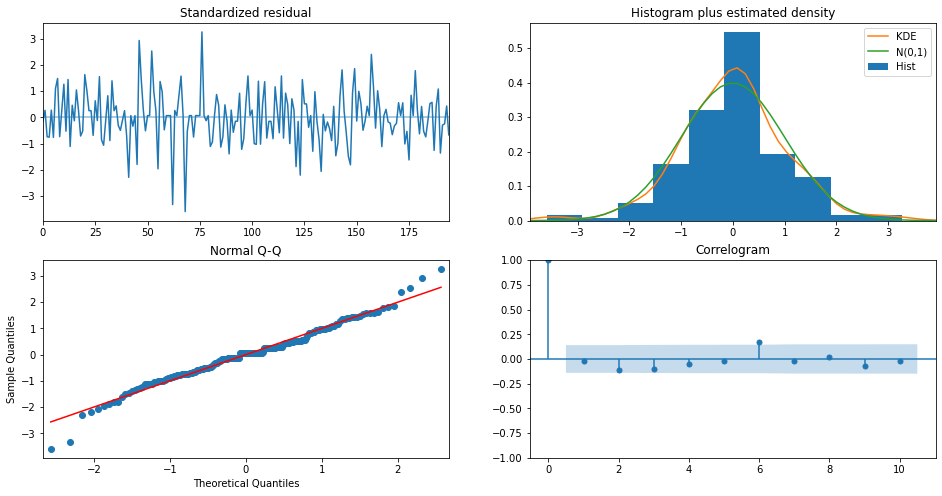

In [144]:
model_arima.plot_diagnostics(figsize=(16,8))
plt.show()

Correlgram을 보면 잔차에 대한 ACF가 범위내에 있음을 확인할수있다 


In [145]:
prediction = model_arima.predict(n_periods=len(y_test))


prediction = pd.DataFrame(prediction,index=y_test.index,columns=["Prediction"])



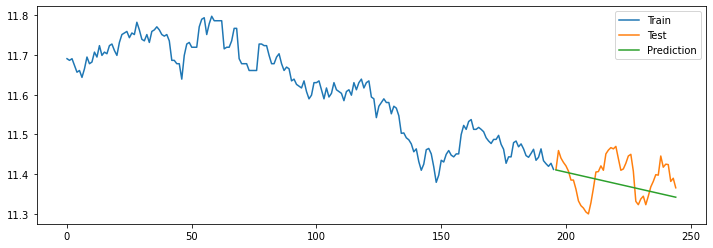

In [146]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
plt.plot(y_train,label="Train")
plt.plot(y_test,label="Test")
plt.plot(prediction,label="Prediction")
plt.legend()
plt.show()

In [147]:
auto_arima_model = auto_arima(y_train,start_p=1,start_q=1,max_p=3,
                             max_q=3,m=12,seasonal=True,
                             d=1,D=1,max_P=3,max_Q=3,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-750.086, Time=1.66 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=inf, Time=3.02 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-804.796, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=2.10 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=3.22 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-830.005, Time=0.31 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=4.04 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=inf, Time=3.23 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=-832.716, Time=0.47 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=2.04 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=inf, Time=3.80 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-749.19

In [148]:
auto_arima_model.summary() # 자동으로 최적값 적용되었다고 보니까 바로 summary해도 됨 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  196
Model:             SARIMAX(2, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                 433.969
Date:                                 Tue, 22 Nov 2022   AIC                           -855.937
Time:                                         01:23:26   BIC                           -836.681
Sample:                                              0   HQIC                          -848.132
                                                 - 196                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5557      0.410      1.356      0.175      -0.247       1.359
ar.L2         -0.0985      0.087     -1.138      0.255      -0.268       0.071
ma.L1         -0.5839      0.402     -1.453      0.146      -1.371       0.204
ma.S.L12      -0.9791      0.103     -9.485      0.000      -1.181      -0.777
ma.S.L24       0.1336      0.092      1.457      0.145      -0.046       0.313
sigma2         0.0005   5.25e-05      8.869      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 4.73
Prob(Q):                              0.86   Prob(JB):                         0.09
Heteroskedasticity (H):               0.67   Skew:                            -0.04
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA 모델이 더 좋은 AIC 결과를 얻을수있었다 

In [149]:
def forecast_one_step():
    fc,conf_int = model_arima.predict(n_periods=1,return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )


한스텝식 예측하고 테스트 데이터를 관측할때마다 모형을 업데이트 해주는 refresh전략 
위에 n_period=1들어간 이유가 위와 같다 

-> 예측치들은 결국 가장 마지막 관측치가 되기 때문이다 
결과적으로 데이터에서 어떠한 구조를 보기 어렵기 때문에 가장 마지막 관측치가 가장 좋은 예측치다라고 말하는거이다 



In [150]:
forecasts=[]
y_pred=[]
pred_upper=[]
pred_lower=[]

for new_ob in y_test:
    fc,conf =forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[0])
    pred_lower.append(conf[1])
    
    model_arima.update(new_ob)
    
    

In [151]:
pd.DataFrame({"test":y_test,"pred":y_pred})

,test,pred
196,11.412000,11.410568
197,11.459525,11.410569
198,11.440355,11.458344
199,11.429544,11.439084
200,11.420810,11.428225
201,11.407565,11.419454
202,11.385092,11.406149
203,11.385092,11.383572
204,11.362103,11.383576
205,11.332602,11.360490


In [152]:
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  245
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 589.273
Date:                Tue, 22 Nov 2022   AIC                          -1174.547
Time:                        01:23:28   BIC                          -1167.552
Sample:                             0   HQIC                         -1171.730
                                - 245                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0013      0.001     -0.963      0.336      -0.004       0.001
sigma2         0.0005   3.36e-05     13.895      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.38   Jarque-

In [153]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


fig = go.Figure([
    go.Scatter(x=y_train.index,y=y_train,name="Train",mode="lines",line= dict(color="royalblue"))
    ,go.Scatter(x=y_test.index,y=y_test,name="Test",mode="lines",line= dict(color="rgba(0,0,30,0.5)"))
    ,go.Scatter(x=y_test.index,y=y_pred,name="Prediction",mode="lines",line= dict(color="red",dash="dot"))
    ,go.Scatter(x=y_test.index.tolist()+y_test.index[::-1].tolist(),y=pred_upper+pred_lower[::-1],fill="toself",
               fillcolor="rgba(0,0,30,0.1)",line=dict(color="rgba(0,0,0,0)"),
               hoverinfo="skip",
               showlegend=False)
])

fig.update_layout(height=400,width=1000)
fig.show()

In [154]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [155]:

mse = mean_squared_error(np.exp(y_test), np.exp(prediction))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(y_test), np.exp(prediction))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(y_test), np.exp(prediction)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(y_pred) - np.exp(y_test))/np.abs(np.exp(y_test)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  23340939.47497082
MAE:  4181.198128683192
RMSE:  4831.246161703089
MAPE: 1.87%


# 회고 

이번 arima 모델 실습을 통해 삼성 주가와 sk 하이닉스 주가에 대한 시계열 분석을 진행 하였다 

이번 실습을 통해 arima 모델에 대한 이론이 더 탄탄해 진것 같다. ACF,PACF ,differencing 그래프를 직접 확인함으로써
아르마 모델에 파라미터를 어떻게 정해야 하고 분석 해야 하는지 알수있었다.  ndiff를 통해 필요한 차분 계수를 추정할수있었다 
삼성 주가 실습 할때 ndiif를 통해 차분 추정을 해주었다 그래서 p,q를 정하면 되었다. 
하지만 삼성 주가 같은 경우 differencing 통해 ACF PACF모두 보았지만 cut off되는 지점을 찾기가 어려워서 
p와 q 모두 5~ 28까지 모두 돌려 주었다 그리고 최적의 지점을 찾아서 그 주변을 다시 auto arima 모델로 돌려보기로 했다 
p와 q 모두 5~28까지 범위를 맞추어서 시간이 많이 걸렸다 그래서 sk 하이닉스의 주가 분석 같은 경우 똑같이 하지 않았고 
그냥 눈대중으로 cut off 되는 지점을 찾아서 auto arima 돌리기로 했다 
그리고 이번 실습을 통해 시각화 하는게 중요하다는것을 체감 했다. trend와 seanoality,cycle을 파악하기 위해 시각화는 필수인것 같다 
이것을 바탕으로 SARIMAX모델을 사용할지 ARIMA 모델을 사용할지 결정할수있었던것 같다 
그리고 분산을 안정화 해야 한다면 log를 통해 분산을 안정화 해줄수있다는 사실도 알게 되었다 
그리고 auto arima를 공부하면서 잔차에 대한 검정 통걔량에 대해 알수있었다
Ljung Box : 잔차가 백색소음인지 검정한 통계량이다  이 통계량의 귀무 가설은 resdiual가 백색잡음시계열을 따른다 이다
prob Q : 이 값을 통해 Ljung Box의 귀무가설을 기각할수있을지 결정할수있다. 0.05에서 귀무가설을 기각할수있을지 볼수있다 

만약 귀무가설을 기각 하지 못했다면 시계열 모형이 잘 적합되었고 남은 잔차는 더이상 자기 상관을 가지지 않는 백색잡음임을 확인할수있다

jarque Bera(JB) : 잔차가 정규성을 띠는지 검정한 통계량이다 귀무가설은 잔차가 정규성을 만족한다 이다 


그리고 마지막으로 plot_diagnostics()함수를 통해 확인할수있는 내용을 보면 

Standardized redual은 잔차를 시계열로 표현한것이다 
correlogram은 잔차에 대한 ACF이다  ACF의 허용 범위 확인할수있다 


sk 하이닉스보면 SARIMA 모델에서 AIC 결과가 더 좋았다 

참고 
https://assaeunji.github.io/data%20analysis/2021-09-25-arimastock/
